# Приложение №1. Визуализация и анализ результатов обработки данных
## Аномалии температуры на ВЕР с 1940 по 2014

## Загрузка данных

In [869]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import xarray as xr

import os
import math as m

In [4]:
from IPython.display import display,HTML
display(HTML('<style>.container {width: 80% !important}</style>'))

In [6]:
directory = "E:/Climate/t7/"

file_list = np.array ([file for file in os.listdir(directory) if file.endswith('.nc')])

In [191]:
# Aggregating files by dictionaries: 
# timcor (2d spatial data), fldcor (array of values by timesteps), timmean (single value)
# tr_A and tr_B contain parameters of linear trends of anomalies time series (average values for shift and slope)
file_dict = {}
timcor = {}
fldcor = {}
timmean = {}
tr_A = {}
tr_B = {}
for file in file_list:
    dataset = xr.open_dataset(os.path.join(directory, file), decode_times=False)
    file_dict[file] = dataset
    if 'timcor' in file:
        timcor[file] = dataset
    if 'fldcor' in file and not 'timmean' in file:
        fldcor[file] = dataset
    if 'timmean' in file:
        timmean[file] = dataset
    if 'fldmean_trend1' in file:
        tr_A[file.split('trend1_')[1]] = dataset
    if 'fldmean_trend2' in file:
        tr_B[file.split('trend2_')[1]] = dataset

## Функции для отображения наборов данных в виде карт и временных рядов

In [333]:
def data_disp (keyword, stopword, data_dict, columns, n_lat, n_lon, pos_in_filename, title,
               scale_min, scale_max, fig_name):

    #### Displayig 25 timcors --- this will work only for 2d arrays with 1 timestep
    if keyword == '' and stopword == '':
        data_list = np.array([file for file in data_dict.keys()])
    elif stopword == '':
        data_list = np.array([file for file in data_dict.keys() if keyword in file])
    else:
        data_list = np.array([file for file in data_dict.keys() if (keyword in file and not stopword in file)])
    
    data_list = np.sort(data_list)
    n_subs = m.ceil(len(data_list)/columns)*columns
    fig, ax = plt.subplots(n_subs//columns, columns, figsize=(4*columns, 1.5+2*(n_subs//columns)), layout='constrained') 
    fig.suptitle (title, fontsize=18)

    for i in range(len(data_list)):
        row = i // columns
        column = i % columns
        
        variable = list(data_dict[data_list[i]].variables)[-1]
        array = data_dict[data_list[i]][variable][0]
        name = data_list[i].split('_')[pos_in_filename]
        
        plotted = ax[row, column].imshow(array[::-1],  vmin=scale_min, vmax=scale_max, cmap='RdYlBu_r') # best scale for timcor t7: -0.25, 0.35
        ax[row, column].set_title(name, fontsize=14)

        if n_lat*n_lon != 0:
            # Counting how to place ticks
            longitudes = np.array (array['lon'], dtype='int')
            latitudes = np.array (array['lat'][0:180]+0.5, dtype='int')
            lon_step = len(longitudes)//(n_lon-1)
            lat_step = m.ceil(len(latitudes)/(n_lat))

            ax[row, column].tick_params(length=2, labelsize=10)
            ax[row, column].set_xticks(np.arange(0, len(longitudes), lon_step))
            ax[row, column].set_xticklabels(list(str(lon) + 'E' for lon in longitudes[::lon_step]))
            ax[row, column].set_yticks(np.arange(0, len(latitudes), lat_step))
            ax[row, column].set_yticklabels(list(str(lat) + 'N' for lat in latitudes[-1::-lat_step]))
            ax[row, column].grid(color='black', linestyle='dashed', linewidth=0.5, alpha=0.2)
    for i in range(n_subs):
        row = i // columns
        column = i % columns
        if i >= len(data_list):
            fig.delaxes(ax[row][column])
            
    cbar = fig.colorbar(plotted, ax=ax, location='bottom', anchor=(0.5, 0.5), shrink=0.4, extend='both', orientation='horizontal', aspect=40)
    plt.show()
    
    if (fig_name != '' and not '.' in fig_name):    fig.savefig('t7_fig/'+fig_name+'.png', dpi=300)
    if (fig_name != '' and fig_name.endswith('.eep')):    fig.savefig('t7_fig/'+fig_name)

In [474]:
def data_plot (keyword, stopword, data_dict, columns, pos_in_filename, title, fig_name, step):

    #### Displayig 25 fldcor --- as 25 plots with y = value and x = time
    
    # making a list of files for display
    if keyword == '' and stopword == '':
        data_list = np.array([file for file in data_dict.keys()])
    elif stopword == '':
        data_list = np.array([file for file in data_dict.keys() if keyword in file])
    else:
        data_list = np.array([file for file in data_dict.keys() if (keyword in file and not stopword in file)])
    data_list = np.sort(data_list)
    n_subs = m.ceil(len(data_list)/columns)*columns
    
    fig, ax = plt.subplots(n_subs//columns, columns, figsize=(4*columns, 1.5+2*(n_subs//columns)), layout='constrained') 
      
    fig.suptitle (title, fontsize=14)
    
    array = data_dict[data_list[0]]
    df = array.to_dataframe(['time', 'bnds', 'lon', 'lat']).reset_index()
    roll = df.rolling(step).mean()
    row = 0 // columns
    column = 0 % columns
    
    for i in range(len(data_list)):
        row = i // columns
        column = i % columns
       
        variable = list(data_dict[data_list[i]].variables)[-1]
        name = str('-'.join(data_list[i].split('_')[pos_in_filename:next((index for index, elem in enumerate(data_list[i].split('_')) if 'ssp' in elem), None)]))
        array = data_dict[data_list[i]]
        df = array.to_dataframe(['time', 'bnds', 'lon', 'lat']).reset_index()
        df = df[df['bnds'] == 1]
        
        ax[row, column].plot(np.arange(1940, 2015), df[variable], alpha=0.6)
        
        ax[row, column].set_ylim(-1, 1)  
        ax[row, column].set_title(name, fontsize=10)
        ax[row, column].tick_params(length=2, labelsize=10)
        ax[row, column].text(1940, 0.8, round(float(timmean['timmean_'+data_list[i]][variable].values), 3))

        if step > 1:
            df = array.to_dataframe(['time', 'bnds', 'lon', 'lat']).reset_index()
            df = df[df['bnds'] == 1]
            
            roll = df.rolling(step).mean()
            ax[row, column].plot(np.arange(1940, 2015), roll[variable], linestyle='-', color='red')
    
    for i in range(n_subs):
        row = i // columns
        column = i % columns
        if i >= len(data_list):
            fig.delaxes(ax[row][column])

        ax[row, column].grid(color='black', linestyle='dotted', linewidth=0.5, alpha=0.4)
    plt.show()
    if (fig_name != '' and not '.' in fig_name):    fig.savefig('t7_fig/'+fig_name+'.png', dpi=300)
    if (fig_name != '' and fig_name.endswith('.eep')):    fig.savefig('t7_fig/'+fig_name)

## Визуализация

Opened: tas_Amon_ACCESS-CM2_ssp585_r1i1p1f1_185001-210012_r360x180_remap.nc


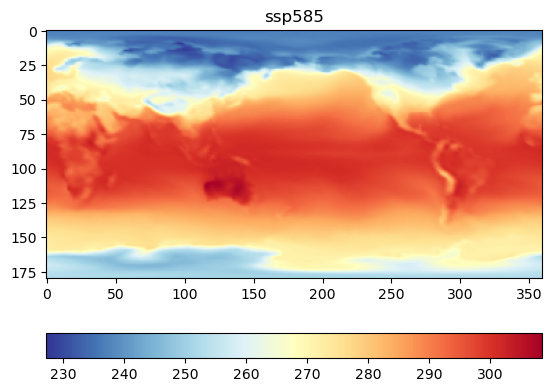

In [907]:
# How to plot one file
file = list(file_dict.keys())[0]
variable = str(list(file_dict[file].variables)[-1])

plt.imshow(file_dict[file][variable][0][::-1], cmap='RdYlBu_r')

plt.title(file.split('_')[3], fontsize=12)
plt.colorbar(orientation='horizontal')
print(f"Opened: {file}")
plt.show()

In [11]:
# Open timcors from my directory
i = 0
for file in file_dict.keys():
    if ('timcor' in file and not '__' in file):
        print (file)
        i+=1
print(f"Total: {i}")

timcor_tas_Amon_UKESM1-0-LL_ssp585_r1i1p1f2_185001-210012_r360x180_remap_C_regular_axis_year_anom_box_ymean.nc
timcor_tas_Amon_ACCESS-CM2_ssp585_r1i1p1f1_185001-210012_r360x180_remap_C_regular_axis_year_anom_box_ymean.nc
timcor_tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_185001-210012_r360x180_remap_C_regular_axis_year_anom_box_ymean.nc
timcor_tas_Amon_AWI-CM-1-1-MR_ssp585_r1i1p1f1_185001-210012_r360x180_remap_C_regular_axis_year_anom_box_ymean.nc
timcor_tas_Amon_BCC-CSM2-MR_ssp585_r1i1p1f1_185001-210012_r360x180_remap_C_regular_axis_year_anom_box_ymean.nc
timcor_tas_Amon_CAMS-CSM1-0_ssp585_r1i1p1f1_185001-210012_r360x180_remap_C_regular_axis_year_anom_box_ymean.nc
timcor_tas_Amon_CESM2-WACCM_ssp585_r1i1p1f1_185001-210012_r360x180_remap_C_regular_axis_year_anom_box_ymean.nc
timcor_tas_Amon_CESM2_ssp585_r1i1p1f1_185001-210012_r360x180_remap_C_regular_axis_year_anom_box_ymean.nc
timcor_tas_Amon_CMCC-ESM2_ssp585_r1i1p1f1_185001-210012_r360x180_remap_C_regular_axis_year_anom_box_ymean.nc
timcor

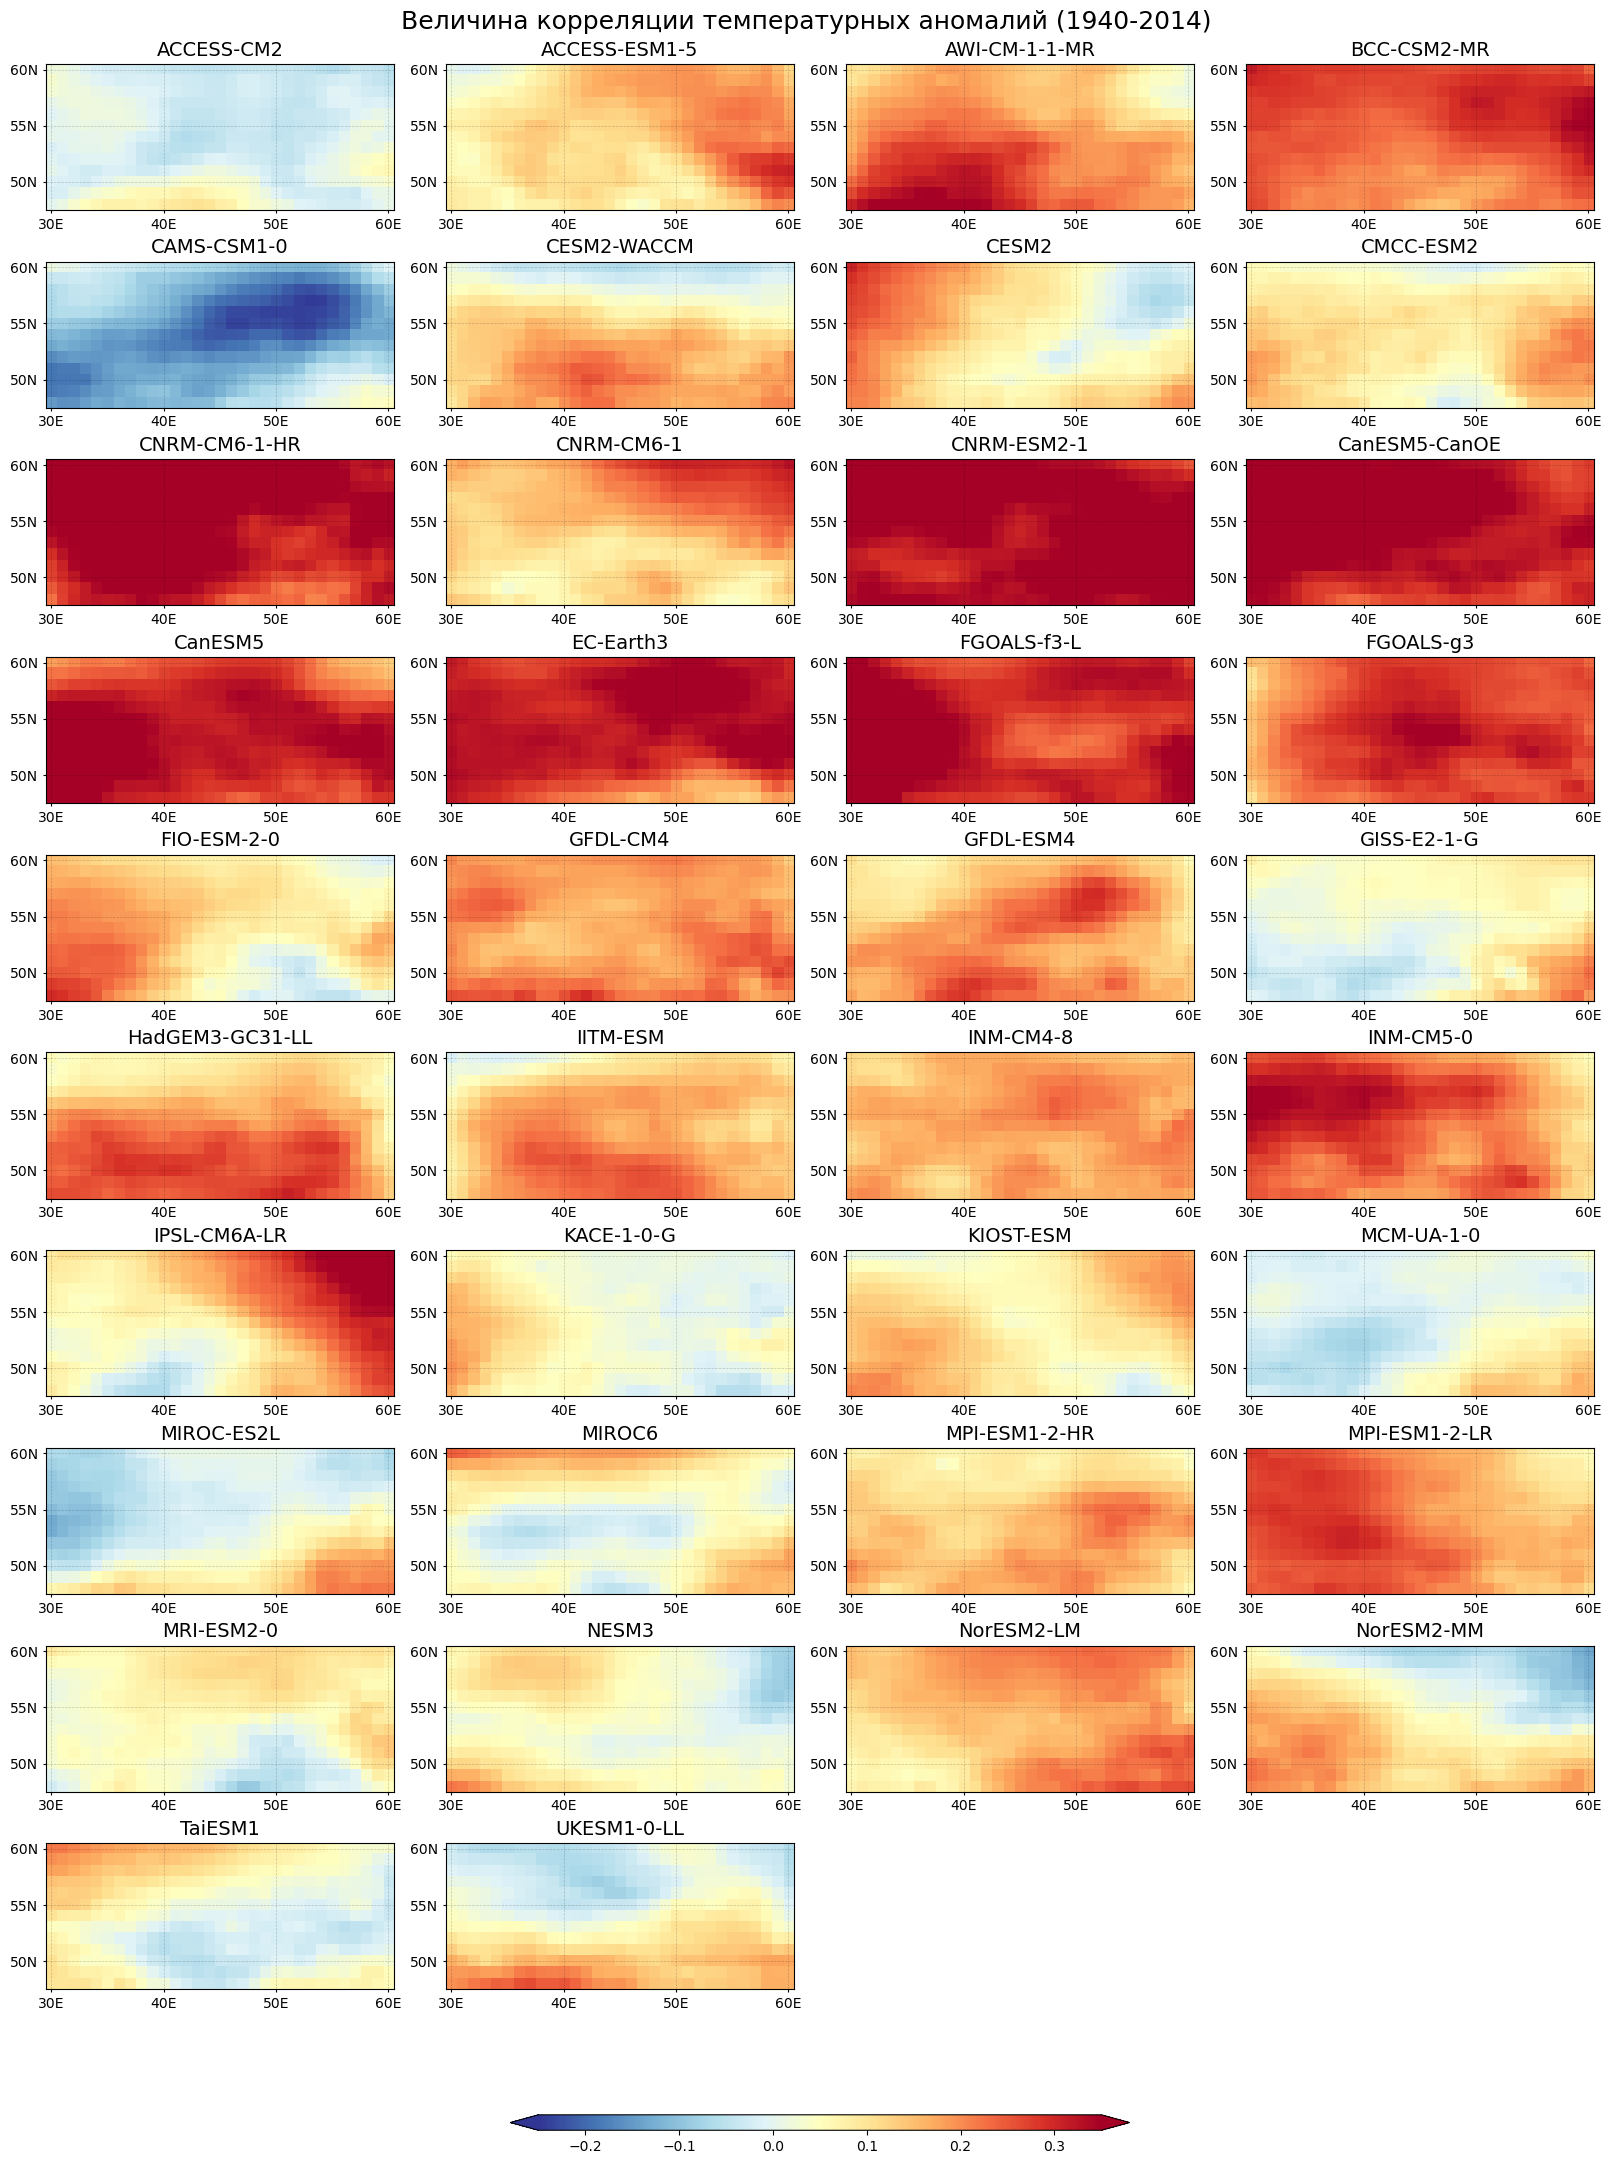

In [264]:
data_disp ('', '', timcor, 4, 3, 4, 3, "Величина корреляции температурных аномалий (1940-2014)", -0.25, 0.35, '')

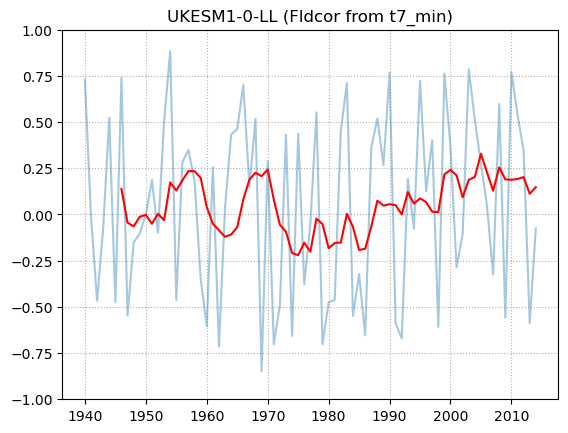

In [461]:
# Plotting fldcor
file = 'fldcor_tas_Amon_UKESM1-0-LL_ssp585_r1i1p1f2_185001-210012_r360x180_remap_C_regular_axis_year_anom_box_ymean.nc'
df = fldcor[file].to_dataframe(['time', 'bnds', 'lon', 'lat']).reset_index()
step = 7
df = df[df['bnds'] == 1]

plt.plot(np.arange(1940, 2015,1), df['tas'], alpha=0.4)

roll = df.rolling(step).mean()
plt.plot(np.arange(1940, 2015,1), roll['tas'], linestyle='-', color='red')

plt.title(file.split('_')[3] + " (Fldcor from t7_min)")
plt.grid(linestyle=':')
plt.ylim(-1,1)
plt.show()

In [14]:
# Open fldcors from my directory
i = 0
for file in file_dict.keys():
    if ('fldcor' in file and not 'timmean' in file):
        print (file)
        i+=1
print(f"Total: {i}")

fldcor_tas_Amon_UKESM1-0-LL_ssp585_r1i1p1f2_185001-210012_r360x180_remap_C_regular_axis_year_anom_box_ymean.nc
fldcor_tas_Amon_ACCESS-CM2_ssp585_r1i1p1f1_185001-210012_r360x180_remap_C_regular_axis_year_anom_box_ymean.nc
fldcor_tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_185001-210012_r360x180_remap_C_regular_axis_year_anom_box_ymean.nc
fldcor_tas_Amon_AWI-CM-1-1-MR_ssp585_r1i1p1f1_185001-210012_r360x180_remap_C_regular_axis_year_anom_box_ymean.nc
fldcor_tas_Amon_BCC-CSM2-MR_ssp585_r1i1p1f1_185001-210012_r360x180_remap_C_regular_axis_year_anom_box_ymean.nc
fldcor_tas_Amon_CAMS-CSM1-0_ssp585_r1i1p1f1_185001-210012_r360x180_remap_C_regular_axis_year_anom_box_ymean.nc
fldcor_tas_Amon_CESM2-WACCM_ssp585_r1i1p1f1_185001-210012_r360x180_remap_C_regular_axis_year_anom_box_ymean.nc
fldcor_tas_Amon_CESM2_ssp585_r1i1p1f1_185001-210012_r360x180_remap_C_regular_axis_year_anom_box_ymean.nc
fldcor_tas_Amon_CMCC-ESM2_ssp585_r1i1p1f1_185001-210012_r360x180_remap_C_regular_axis_year_anom_box_ymean.nc
fldcor

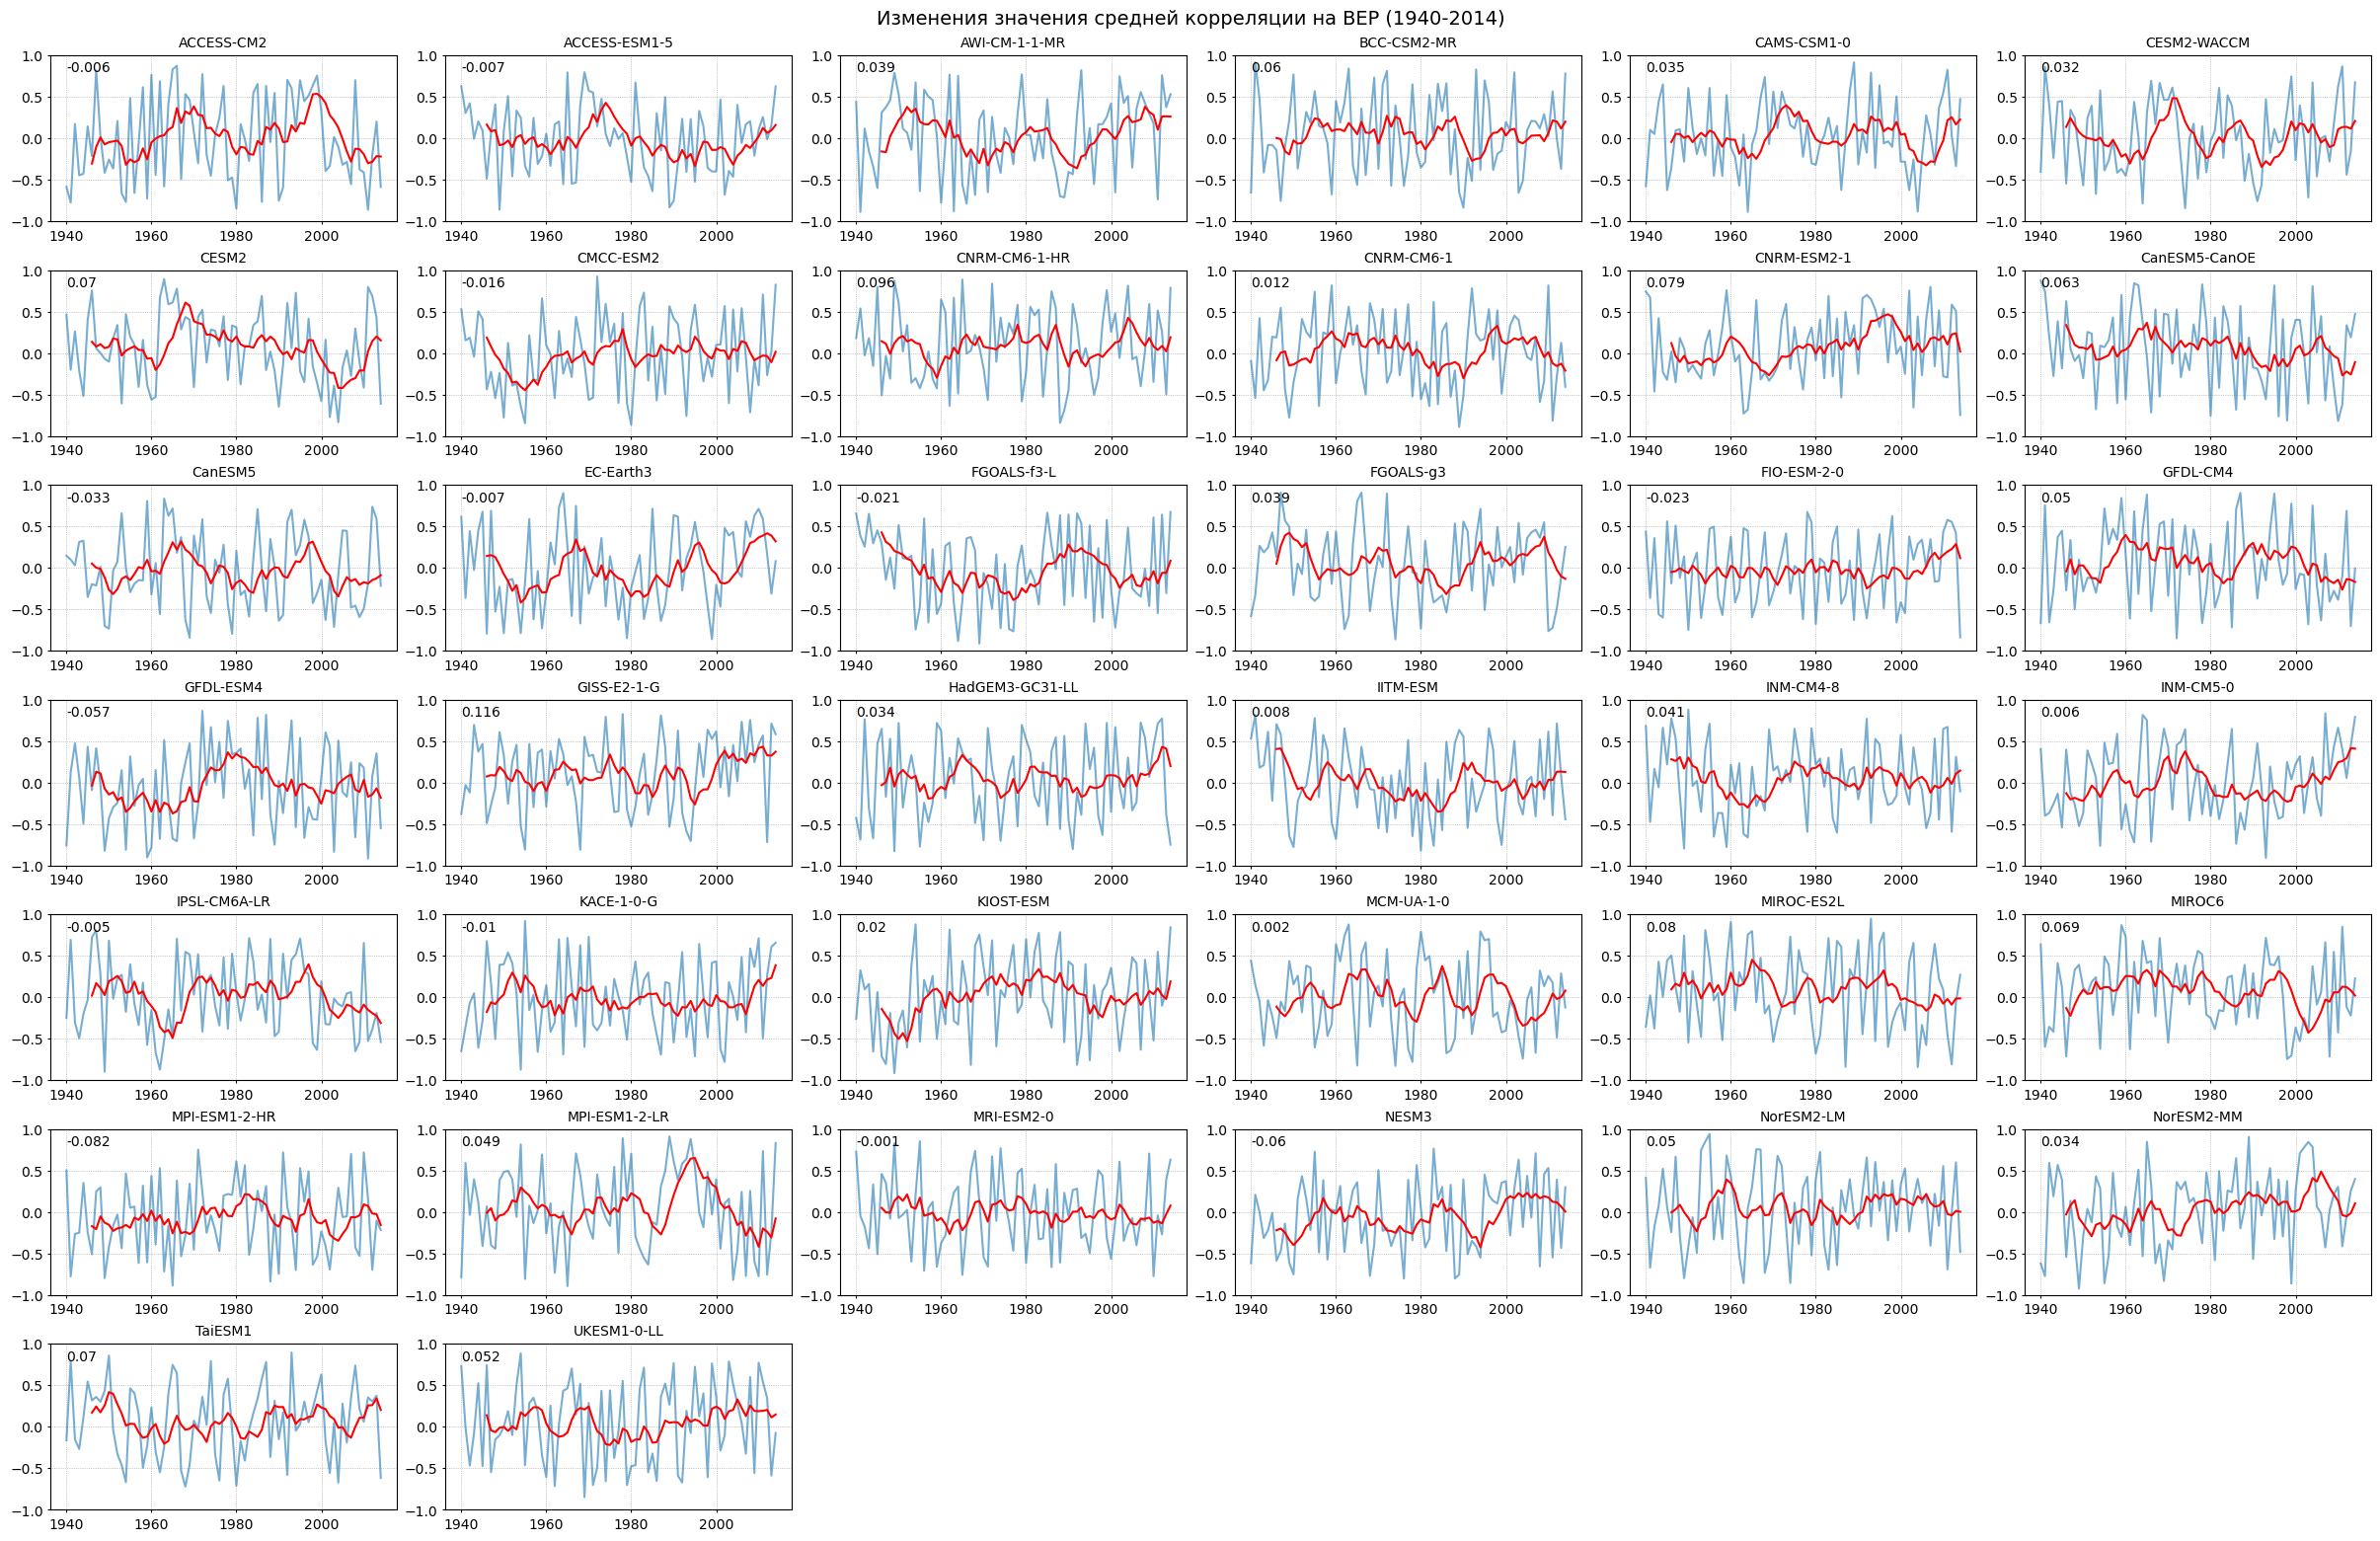

In [475]:
data_plot ('fldcor', 'timmean', file_dict, 6, 3, "Изменения значения средней корреляции на ВЕР (1940-2014)", '', 7)

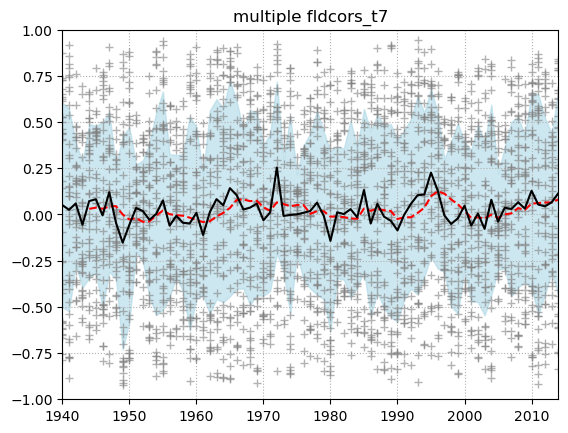

In [898]:
# Plotting many fldcors on one plot and mean for some reason
step = 5
df = df[df['bnds'] == 1]
dfs = []
for file in list(fldcor.keys()):
    df = file_dict[file].to_dataframe(['time', 'bnds', 'lon', 'lat']).reset_index()
    df = df[df['bnds'] == 1]
    dfs.append(df)
    plt.plot(np.arange(1940, 2015,1), df['tas'], alpha=0.6, marker='+', linestyle="", color='gray')

    roll = df.rolling(step).mean()
#     plt.plot(np.arange(1940, 2015,1), roll['tas'], linestyle='--', alpha=0.4)

df_conc = pd.concat(dfs, axis=1)
roll_conc = df_conc.tas.mean(axis=1).rolling(step).mean()

plt.plot(np.arange(1940, 2015,1), roll_conc, linestyle='--', alpha=1, color='red')
plt.plot(np.arange(1940, 2015,1), df_conc.tas.mean(axis=1), linestyle='-', alpha=1, color='black')
plt.fill_between(np.arange(1940, 2015,1), df_conc.tas.mean(axis=1)+df_conc.tas.std(axis=1), df_conc.tas.mean(axis=1)-df_conc.tas.std(axis=1), color='lightblue', alpha=0.6)

plt.title("multiple fldcors_t7")
plt.grid(linestyle=':')
plt.ylim(-1,1)
plt.xlim(1940, 2014)
plt.show()
# plt.savefig("many_fldcors_t7_min.png")

## Оценка моделей: средняя корреляция

In [522]:
# Ranking models by timmean

model_df = pd.DataFrame(columns=['model', 'timmean', 'shift', 'slope'])

for i in range(1, len(list(timmean.keys()))+1):
    file = list(timmean.keys())[i-1]
    variable = list(timmean[file].variables)[-1]
    model_df.loc[i, 'model'] = file.split('_')[4]
    model_df.loc[i, 'timmean'] = float(timmean[file][variable].values)
model_df[model_df['timmean'] == model_df.timmean.max()]

,model,timmean,shift,slope
21,GISS-E2-1-G,0.115555,NaN,NaN


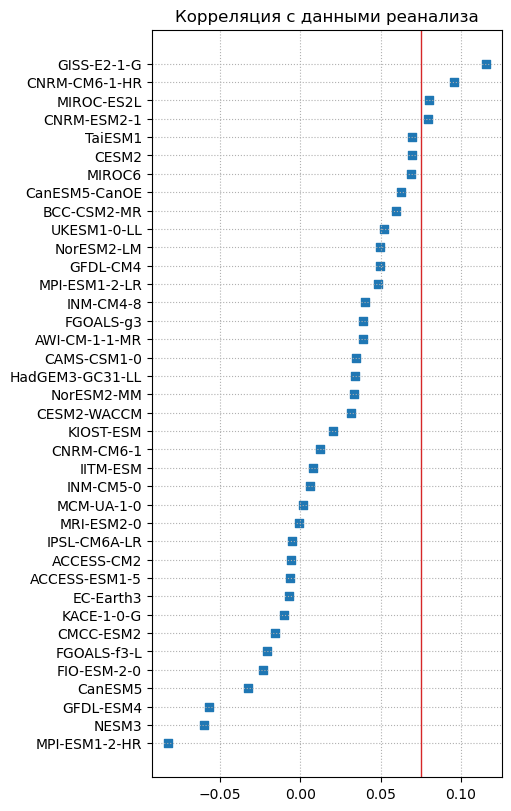

In [732]:
# Ranking models
plt.figure(figsize=(5, 8), layout='constrained')

# file = 'timmean_fldcor_tas_Amon_ACCESS-CM2_ssp585_r1i1p1f1_185001-210012_r360x180_remap_C_regular_axis_year_anom_box_ymean.nc'

timmean_sorted = model_df.sort_values(by='timmean', ascending=False).reset_index()
plt.scatter(model_df.sort_values(by='timmean', ascending=True).reset_index().timmean, model_df.sort_values(by='timmean', ascending=True).reset_index()['model'],
            marker='s', c='C10')
plt.yticks(timmean_sorted['model'])
plt.grid(linestyle=':')

plt.axvline(x=0.075, color='C3', linestyle='-', lw=1.)         # <-- treshold
plt.title("Корреляция с данными реанализа")

# plt.show()
plt.savefig("t7_fig/mean_corr.png", dpi=300)

## Тренды

In [492]:
# Add dataframe for reanalysis
for file in file_list:
    if 'ERA5' in file and not '_ERA5' in file:
        reanalysis = file
        break
rean_df = pd.DataFrame({'model':['ERA5'], 'timmean':[1], 'shift':[float(tr_A[reanalysis].t2m.values)], 'slope':[float(tr_B[reanalysis].t2m.values)]})
rean_df

,model,timmean,shift,slope
0,ERA5,1,-0.827001,0.027118


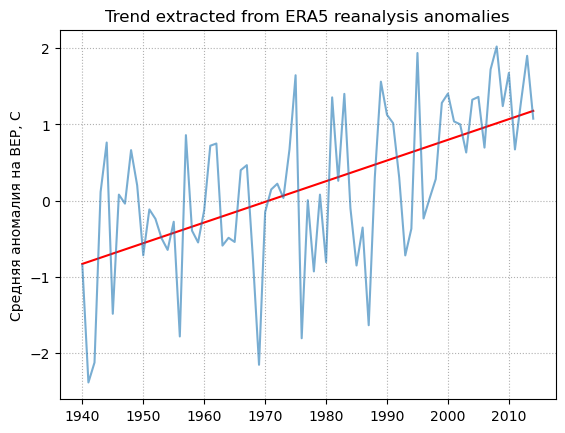

In [688]:
# Display trend in anomalies_box_yearmean in reanalysis to prove that the slope matches the anomalies

fldmean_anom = pd.DataFrame(columns=['timestep', 'fldmean'])
for i in range(len(file_dict[reanalysis].time.values)):
    time0 = pd.DataFrame(file_dict[reanalysis].t2m.values[i,0,:,:]).mean().mean()
    fldmean_anom.loc[i, :] = [i, time0]

a = rean_df['shift'][0]
b = rean_df['slope'][0]
x = np.linspace (1940, 2014, 75)

y = a + b*x
s = y - fldmean_anom.fldmean
y_shift = y - s.mean()

plt.plot(x, y_shift, linestyle='-', color='red')
plt.plot(x, fldmean_anom.fldmean, alpha=0.6)

plt.title("Trend extracted from ERA5 reanalysis anomalies")
plt.ylabel("Средняя аномалия на ВЕР, C")
plt.grid(linestyle=':')
plt.show()

In [549]:
# Adding shift and slope values for models
trend_list = list(tr_A.keys())

for i in range(1, len(trend_list)):
    file = trend_list[i]
    variable = list(tr_A[file].variables)[-1]
    model_df['shift'][model_df['model'] == trend_list[i].split('_')[2]] = float(tr_A[file][variable].values)
    model_df['slope'][model_df['model'] == trend_list[i].split('_')[2]] = float(tr_B[file][variable].values)

In [558]:
# Adding reanalysis to model_df and saving result

main_df = pd.concat((rean_df, model_df))
# main_df.to_csv('tables/t7.csv', index=True)

In [784]:
timmean_sorted

,index,model,timmean,shift,slope
0,21,GISS-E2-1-G,0.115555,0.021123,-0.002109
1,10,CNRM-CM6-1-HR,0.096003,-0.434586,0.015465
2,30,MIROC-ES2L,0.080106,0.424714,0.001775
3,12,CNRM-ESM2-1,0.079374,-0.787199,0.028038
4,38,TaiESM1,0.069906,0.142638,0.003899
5,8,CESM2,0.069746,0.050262,0.007296
6,31,MIROC6,0.068828,-0.196257,0.006182
7,13,CanESM5-CanOE,0.062605,-0.440278,0.018306
8,5,BCC-CSM2-MR,0.059884,-0.3366,0.011231
9,1,UKESM1-0-LL,0.052351,0.678814,-0.001549


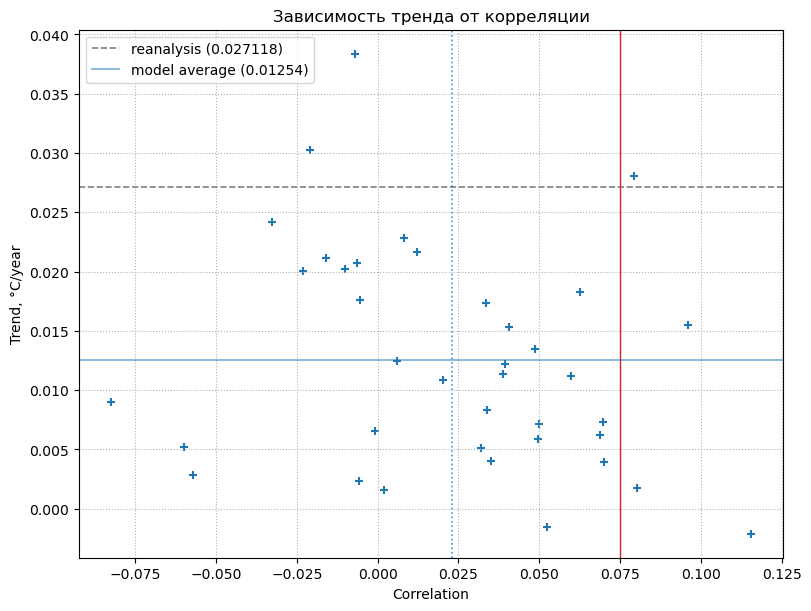

In [881]:
# Try to find connection between slope and correlation
size = model_df['shift']
plt.figure(figsize=(8,6), layout='constrained')
# print(size)
plt.scatter(model_df['timmean'], model_df['slope'], c='C0', marker='+')

plt.axline(xy1=(0,rean_df['slope'][0]), xy2=(0.1,rean_df['slope'][0]), color='gray', linestyle='--', lw=1.2,
           alpha=1.0, label=f"reanalysis ({round(rean_df['slope'][0], 6)})")
plt.axline(xy1=(0.075,0), xy2=(0.075,0.01), color='C3', linestyle='-', lw=1.)

plt.axline(xy1=(model_df['timmean'].mean(), 0), xy2=(model_df['timmean'].mean(), 0.01), alpha=0.8, c='C0', lw=1.2, ls=':')
plt.axline(xy1=(0, model_df['slope'].mean()), xy2=(0.01, model_df['slope'].mean()), alpha=0.6, c='C0', lw=1.2,
           label=f"model average ({round(model_df['slope'].mean(),6)})")

plt.grid(linestyle=':')
plt.xlabel("Correlation")
plt.ylabel("Trend, °C/year")
plt.title("Зависимость тренда от корреляции")
plt.legend()

plt.show()
# plt.savefig("t7_fig/slope_and_corr.png", dpi=300)

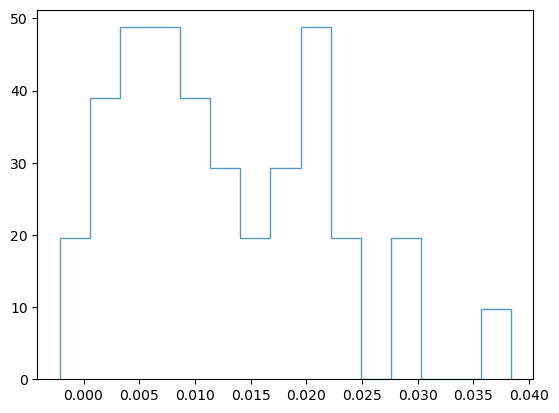

In [882]:
plt.hist(model_df.slope, 15, density=True, histtype='step', facecolor='g',
               alpha=0.75)
# plt.hist(model_df.timmean, 35, density=True, histtype='step', facecolor='g',
#                alpha=0.75)
# plt.hist2d(model_df.timmean, model_df.slope, alpha=0.6)
plt.show()

## Описание